In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [10]:
# Load data for Tram
data = pd.read_csv("/Users/tbhuynh/Desktop/UNC_PHD/BIOS635/Final Project/train.csv")
submission = pd.read_csv("/Users/tbhuynh/Desktop/UNC_PHD/BIOS635/Final Project/test.csv")

# Save the 'id' column from submission before dropping
submission_ids = submission['id'].copy()

# Drop 'id' and 'Name' from both datasets
data.drop(columns=['id', 'Name'], inplace=True)
submission.drop(columns=['id', 'Name'], inplace=True)


In [16]:
# Load data for Ashley
#data = pd.read_csv("C:/Users/ashle/OneDrive/Documents/Courses/UNC Courses/BIOS 635 - ML/Final/train.csv")
#submission = pd.read_csv("C:/Users/ashle/OneDrive/Documents/Courses/UNC Courses/BIOS 635 - ML/Final/test.csv")

# Data Preprocessing

In [11]:
# Examine data
print(data.shape)
print(submission.shape)

data.head()

(140700, 18)
(93800, 17)


,Gender,Age,City,Working Professional or Student,Profession,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness,Depression
0,Female,49.0,Ludhiana,Working Professional,Chef,NaN,5.0,NaN,NaN,2.0,More than 8 hours,Healthy,BHM,No,1.0,2.0,No,0
1,Male,26.0,Varanasi,Working Professional,Teacher,NaN,4.0,NaN,NaN,3.0,Less than 5 hours,Unhealthy,LLB,Yes,7.0,3.0,No,1
2,Male,33.0,Visakhapatnam,Student,NaN,5.0,NaN,8.97,2.0,NaN,5-6 hours,Healthy,B.Pharm,Yes,3.0,1.0,No,1
3,Male,22.0,Mumbai,Working Professional,Teacher,NaN,5.0,NaN,NaN,1.0,Less than 5 hours,Moderate,BBA,Yes,10.0,1.0,Yes,1
4,Female,30.0,Kanpur,Working Professional,Business Analyst,NaN,1.0,NaN,NaN,1.0,5-6 hours,Unhealthy,BBA,Yes,9.0,4.0,Yes,0


In [12]:
# Examining missing data for training set

# Calculate percentage of NaNs per column
nan = data.isna().mean() * 100

for col, i in nan.items():
    print(f"{col}: {i:.2f}% missing")

Gender: 0.00% missing
Age: 0.00% missing
City: 0.00% missing
Working Professional or Student: 0.00% missing
Profession: 26.03% missing
Academic Pressure: 80.17% missing
Work Pressure: 19.84% missing
CGPA: 80.17% missing
Study Satisfaction: 80.17% missing
Job Satisfaction: 19.84% missing
Sleep Duration: 0.00% missing
Dietary Habits: 0.00% missing
Degree: 0.00% missing
Have you ever had suicidal thoughts ?: 0.00% missing
Work/Study Hours: 0.00% missing
Financial Stress: 0.00% missing
Family History of Mental Illness: 0.00% missing
Depression: 0.00% missing


Academic Pressure, CGPA, and Study Satisfaction all have substantial amount of missing data (80.17%). Replacing it with the mean may introduce bias. 

In [13]:
# Fill numerical variables with median
print(f"Number of rows with NaN in Train: {data.isnull().any(axis=1).sum()}")

for col in data.select_dtypes(include=['number']).columns:  
    data[col].fillna(data[col].median(), inplace=True)

# Fill categorical variables with mode
for col in data.select_dtypes(include=['object']).columns:  
    data[col].fillna(data[col].mode()[0], inplace=True)
    
print(f"Number of rows with NaN in Train now: {data.isnull().any(axis=1).sum()}")    

Number of rows with NaN in Train: 140700
Number of rows with NaN in Train now: 0


In [15]:
# Fill submission numerical with median from training data
for col in submission.select_dtypes(include=['number']).columns:  
    submission[col].fillna(data[col].median(), inplace=True)

# Fill submission categorical with mode from training data
for col in submission.select_dtypes(include=['object']).columns:  
    submission[col].fillna(data[col].mode()[0], inplace=True)

# Doing one-hot encoding
# Convert categorical variables to dummy/indicator variables
data = pd.get_dummies(data, drop_first=True)
submission = pd.get_dummies(submission, drop_first=True)

print(f"Number of rows with NaN in Test now: {submission.isnull().any(axis=1).sum()}")    

Number of rows with NaN in Test now: 0


# Models

In [20]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix
import optuna

def tune_xgb_classifier(data_df):
    # 1. Prepare features and target
    X = data_df.drop('Depression', axis=1)
    y = data_df['Depression']

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=y
    )

    # 2. Define Optuna objective
    def objective(trial):
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 100, 1000, step=100),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
            'max_depth': trial.suggest_int('max_depth', 3, 10),
            'subsample': trial.suggest_float('subsample', 0.5, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
            'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
            'reg_lambda': trial.suggest_float('reg_lambda', 0.1, 10.0, log=True),
            'reg_alpha': trial.suggest_float('reg_alpha', 0.1, 10.0, log=True)
        }

        model = XGBClassifier(**params, use_label_encoder=False, eval_metric='logloss')
        model.fit(X_train, y_train)
        preds = model.predict(X_test)
        return accuracy_score(y_test, preds)

    # 3. Run Optuna study
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=25)

    # 4. Train best model
    best_model = XGBClassifier(**study.best_params, use_label_encoder=False, eval_metric='logloss')
    best_model.fit(X_train, y_train)
    preds = best_model.predict(X_test)

    return best_model, preds


In [22]:
xgb_model, xgb_preds = tune_xgb_classifier(data)

[I 2025-04-16 15:05:42,749] A new study created in memory with name: no-name-45dee897-4f3b-4db0-be72-236fe2a27c9f
/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:05:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2025-04-16 15:05:54,055] Trial 0 finished with value: 0.9386638237384506 and parameters: {'n_estimators': 200, 'learning_rate': 0.13327717252813498, 'max_depth': 6, 'subsample': 0.7875408046454067, 'colsample_bytree': 0.8565958351400924, 'min_child_weight': 7, 'reg_lambda': 9.518243252826313, 'reg_alpha': 7.0718328478248855}. Best is trial 0 with value: 0.9386638237384506.
/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:05:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2025-04-16 15:06:37,132] T

[I 2025-04-16 15:13:08,259] Trial 13 finished with value: 0.9375266524520256 and parameters: {'n_estimators': 400, 'learning_rate': 0.05032883537488458, 'max_depth': 10, 'subsample': 0.6214516878377953, 'colsample_bytree': 0.7691623718398788, 'min_child_weight': 4, 'reg_lambda': 0.23700874020643942, 'reg_alpha': 0.3668986992212972}. Best is trial 5 with value: 0.9393745557924662.
/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:13:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2025-04-16 15:13:15,543] Trial 14 finished with value: 0.938592750533049 and parameters: {'n_estimators': 100, 'learning_rate': 0.062417905133156086, 'max_depth': 7, 'subsample': 0.5961437949737256, 'colsample_bytree': 0.8100611460382194, 'min_child_weight': 6, 'reg_lambda': 2.0474980804186877, 'reg_alpha': 1.0487189696587833}. Best is trial 5 with value: 0.939374555792466

In [32]:
from sklearn.model_selection import cross_val_score
# Split into features and target
X = data.drop('Depression', axis=1)
y = data['Depression']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

k_range = range(1, 16)
cv_scores = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_train, y_train, cv=5, scoring='accuracy')
    cv_scores.append(scores.mean())

# Best k
optimal_k = k_range[np.argmax(cv_scores)]
print(f"Optimal k: {optimal_k}, Accuracy: {max(cv_scores):.4f}")

Optimal k: 15, Accuracy: 0.9274


In [33]:
from sklearn.neighbors import KNeighborsClassifier

# Train K-Nearest Neighbors classifier
knn_model = KNeighborsClassifier(n_neighbors=optimal_k)
knn_model.fit(X_train, y_train)

# Predict
y_pred_knn = knn_model.predict(X_val)

# Evaluation


📊 XGBoost Evaluation Metrics
Accuracy : 0.9394
Precision: 0.8434
Recall   : 0.8183
F1 Score : 0.8307
ROC AUC  : 0.9744


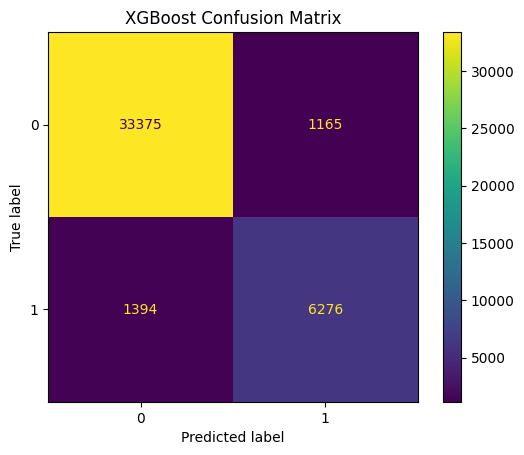

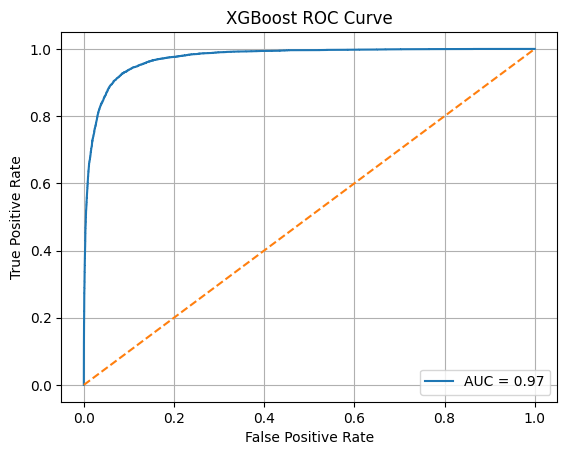

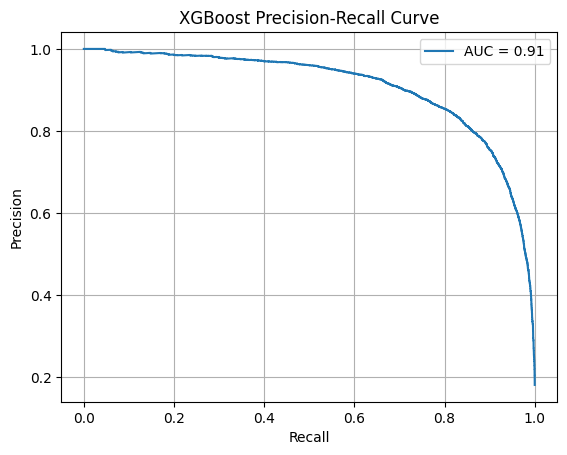


📊 KNN (k=15) Evaluation Metrics
Accuracy : 0.9280
Precision: 0.8034
Recall   : 0.7992
F1 Score : 0.8013
ROC AUC  : 0.9571


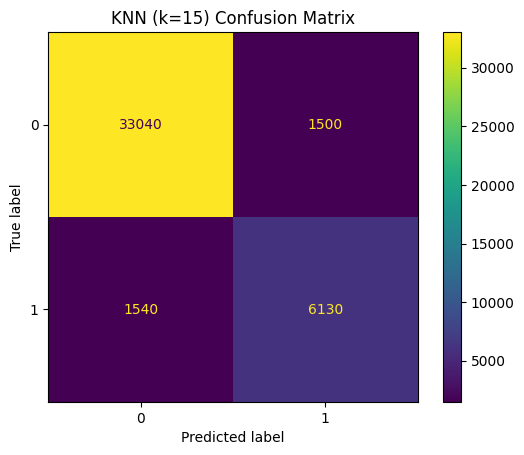

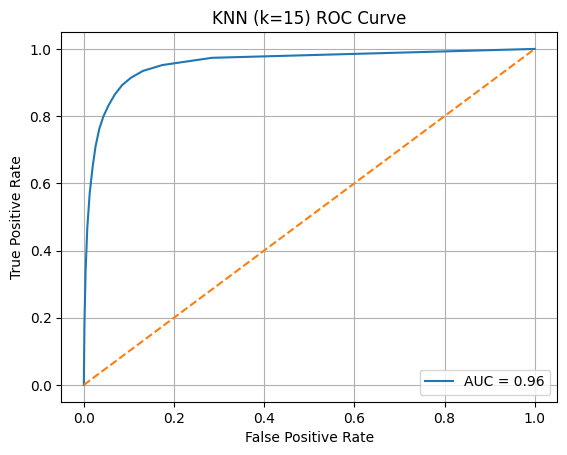

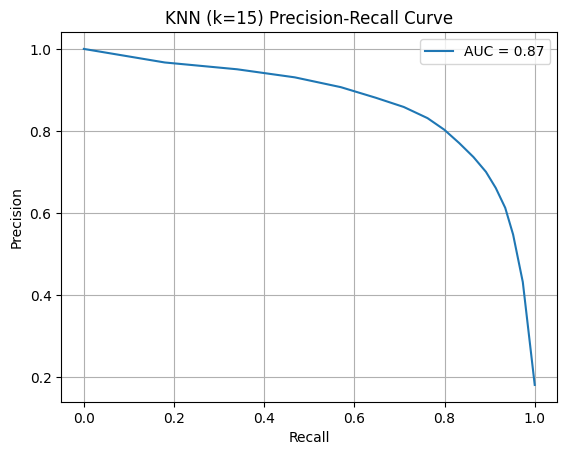


📋 Model Comparison Table
        Model  Accuracy  Precision    Recall  F1 Score   ROC AUC
0     XGBoost  0.939375   0.843435  0.818253  0.830653  0.974362
1  KNN (k=15)  0.927979   0.803408  0.799218  0.801307  0.957145


In [36]:
from sklearn.metrics import (
    recall_score, f1_score, roc_auc_score,
    roc_curve, precision_recall_curve, auc,
    ConfusionMatrixDisplay
)
import matplotlib.pyplot as plt

def evaluate_model(name, y_true, y_pred, y_prob=None):
    print(f"\n📊 {name} Evaluation Metrics")
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    print(f"Accuracy : {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall   : {rec:.4f}")
    print(f"F1 Score : {f1:.4f}")

    if y_prob is not None:
        roc_auc = roc_auc_score(y_true, y_prob)
        print(f"ROC AUC  : {roc_auc:.4f}")
    else:
        roc_auc = None

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    ConfusionMatrixDisplay(cm).plot()
    plt.title(f"{name} Confusion Matrix")
    plt.show()

    # ROC Curve
    if y_prob is not None:
        fpr, tpr, _ = roc_curve(y_true, y_prob)
        plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
        plt.plot([0, 1], [0, 1], linestyle='--')
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title(f"{name} ROC Curve")
        plt.legend()
        plt.grid()
        plt.show()

        # Precision-Recall Curve
        precs, recalls, _ = precision_recall_curve(y_true, y_prob)
        pr_auc = auc(recalls, precs)
        plt.plot(recalls, precs, label=f"AUC = {pr_auc:.2f}")
        plt.xlabel("Recall")
        plt.ylabel("Precision")
        plt.title(f"{name} Precision-Recall Curve")
        plt.legend()
        plt.grid()
        plt.show()

    return {
        "Model": name,
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1 Score": f1,
        "ROC AUC": roc_auc
    }

# Run evaluations
xgb_prob = xgb_model.predict_proba(X_val)[:, 1]
xgb_results = evaluate_model("XGBoost", y_val, xgb_preds, xgb_prob)

knn_prob = knn_model.predict_proba(X_val)[:, 1]
knn_results = evaluate_model(f"KNN (k={optimal_k})", y_val, y_pred_knn, knn_prob)

# Comparison table
comparison_df = pd.DataFrame([xgb_results, knn_results])
print("\n📋 Model Comparison Table")
print(comparison_df)

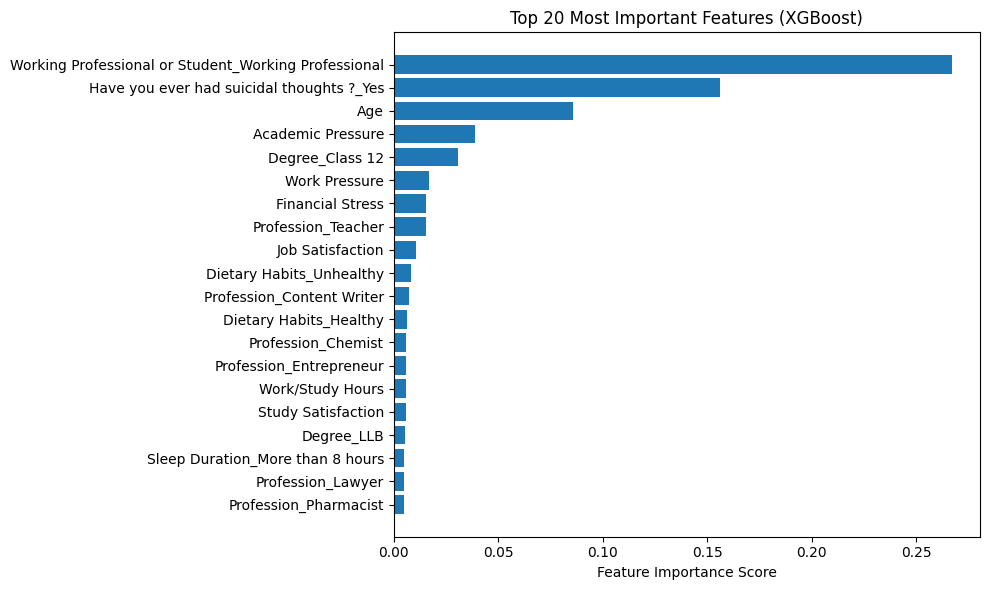

In [37]:
importances = xgb_model.feature_importances_
feature_names = X_train.columns
sorted_idx = np.argsort(importances)[::-1][:20]  # Top 20 features

plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_idx)), importances[sorted_idx][::-1], align='center')
plt.yticks(range(len(sorted_idx)), feature_names[sorted_idx][::-1])
plt.xlabel('Feature Importance Score')
plt.title('Top 20 Most Important Features (XGBoost)')
plt.tight_layout()
plt.show()


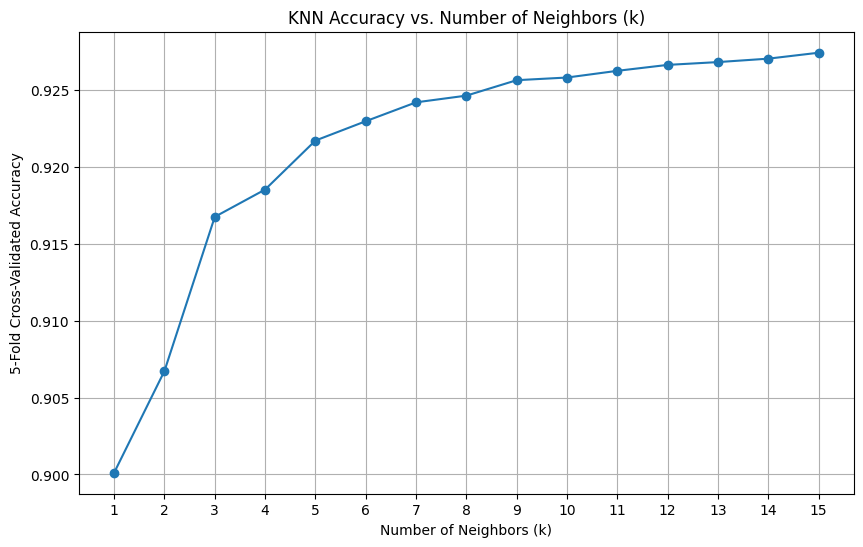

In [38]:
plt.figure(figsize=(10, 6))
plt.plot(k_range, cv_scores, marker='o')
plt.xticks(k_range)
plt.xlabel("Number of Neighbors (k)")
plt.ylabel("5-Fold Cross-Validated Accuracy")
plt.title("KNN Accuracy vs. Number of Neighbors (k)")
plt.grid(True)
plt.show()
